In [1]:
import numpy as np
import pandas as pd
import math
import torch
import config as cfg
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from utility.survival import Survival
from tools.regressors import CoxPH, RSF, DeepSurv, DSM, BNNmcd
from tools.feature_selectors import PHSelector
from utility.builder import Builder
from tools.file_reader import FileReader
from tools.data_ETL import DataETL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines.statistics import proportional_hazard_test
from tools.evaluator import LifelinesEvaluator
from tools.Evaluations.util import predict_median_survival_time
import config as cfg
from sklearn.preprocessing import StandardScaler
from tools.formatter import Formatter
from xgbse.non_parametric import calculate_kaplan_vectorized
from utility.survival import make_event_times
from utility.data import get_window_size, get_lag

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)

plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 12.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

# Paths
DATASET_PATH_XJTU = "../data/XJTU-SY/csv/"
RAW_DATA_PATH_XJTU = ["../data/XJTU-SY/35Hz12kN/", "../data/XJTU-SY/37.5Hz11kN/", "../data/XJTU-SY/40Hz10kN/"]
RESULTS_PATH = "../results"
PLOTS_PATH = "../plots"
RESULT_PATH_XJTU= "../data/XJTU-SY/results/"

NEW_DATASET = False
DATASET = "xjtu"
CONDITION_SELECTOR = 0 # 0, 1, 2
PERCENTAGE = 0.1
TEST_SIZE = 0.3
N_POST_SAMPLES = 1000 # number of samples to draw from MCD posterior
N_CONDITION = len(RAW_DATA_PATH_XJTU)
PLOTS_PATH = PLOTS_PATH
N_BEARING = cfg.N_REAL_BEARING_XJTU
N_SPLITS = 5
TRAIN_SIZE = 1
CENSORING = cfg.CENSORING_LEVEL
DATASET_PATH = DATASET_PATH_XJTU
N_BOOT = 0

In [2]:
#For the first time running, a NEW_DATASET is needed
if NEW_DATASET== True:
    Builder(DATASET, N_BOOT).build_new_dataset(bootstrap=N_BOOT)

# Build timeseries data
timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(CONDITION_SELECTOR, N_BOOT)

# Make moving average
data_util = DataETL(DATASET, N_BOOT)
data = pd.DataFrame()
window_size = get_window_size(N_CONDITION)
lag = get_lag(N_CONDITION)
bearing_indicies =  list(range(1, (N_BEARING*2)+1))
for idx in bearing_indicies:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    data = pd.concat([data, transformed_data], axis=0)
    data = data.reset_index(drop=True)

In [ ]:
from lifelines import CoxPHFitter
from textwrap import fill
import numpy as np
from lifelines.statistics import proportional_hazard_test, TimeTransformers
from lifelines.utils import format_p_value
from lifelines.utils.lowess import lowess

cph = CoxPHFitter() #penalizer= 0.0001
X_spec = data.loc[:, ~data.columns.isin(['Fca','Fi','Fo','Fr','Frp','FoH', 'FiH', 'FrH', 'FrpH', 'FcaH', 'noise'])]
cph.fit(X_spec, duration_col="Survival_time", event_col= "Event")

# Compute and plot PH
training_df = X_spec
advice = True
show_plots = False
p_value_threshold = 0.05
plot_n_bootstraps = 15
columns = None
residuals = cph.compute_residuals(training_df, kind="scaled_schoenfeld")
test_results = proportional_hazard_test(cph, training_df, time_transform=["rank", "km"], precomputed_residuals=residuals)
residuals_and_duration = residuals.join(training_df[cph.duration_col])
Xs = cph.regressors.transform_df(training_df)
counter = 0
n = residuals_and_duration.shape[0]
axes = []
for variable in cph.params_.index.intersection(columns or cph.params_.index):
    minumum_observed_p_value = test_results.summary.loc[variable, "p"].min()
    
    # plot is done (regardless of test result) whenever `show_plots = True`
    if show_plots:
        axes.append([])
        print()
        print("Bootstrapping lowess lines. May take a moment...")
        print()
        from matplotlib import pyplot as plt

        fig = plt.figure()

        # plot variable against all time transformations.
        for i, (transform_name, transformer) in enumerate(TimeTransformers().iter(["rank", "km"]), start=1):
            p_value = test_results.summary.loc[(variable, transform_name), "p"]

            ax = fig.add_subplot(1, 2, i)

            y = residuals_and_duration[variable]
            tt = transformer(cph.durations, cph.event_observed, cph.weights)[cph.event_observed.values]

            ax.scatter(tt, y, alpha=0.75)

            y_lowess = lowess(tt.values, y.values)
            ax.plot(tt, y_lowess, color="k", alpha=1.0, linewidth=2)

            # bootstrap some possible other lowess lines. This is an approximation of the 100% confidence intervals
            for _ in range(plot_n_bootstraps):
                ix = sorted(np.random.choice(n, n))
                tt_ = tt.values[ix]
                y_lowess = lowess(tt_, y.values[ix])
                ax.plot(tt_, y_lowess, color="k", alpha=0.30)

            best_xlim = ax.get_xlim()
            ax.hlines(0, 0, tt.max(), linestyles="dashed", linewidths=1)
            ax.set_xlim(best_xlim)

            ax.set_xlabel("%s-transformed time\n(p=%.4f)" % (transform_name, p_value), fontsize=10)
            ax.grid(True)
            axes[-1].append(ax)

        fig.suptitle("Scaled Schoenfeld residuals of '%s'" % variable, fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.savefig(f'{PLOTS_PATH}/schoenfeld_residuals_cond_{CONDITION_SELECTOR+1}_{variable}.png', format='png', bbox_inches="tight")

    if np.round(minumum_observed_p_value, 2) > p_value_threshold:
        continue

    counter += 1

    if counter == 1:
        if advice:
            print(
                fill(
                    """The ``p_value_threshold`` is set at %g. Even under the null hypothesis of no violations, some covariates will be below the threshold by chance. This is compounded when there are many covariates. Similarly, when there are lots of observations, even minor deviances from the proportional hazard assumption will be flagged."""
                    % p_value_threshold,
                    width=100,
                )
            )
            print()
            print(
                fill(
                    """With that in mind, it's best to use a combination of statistical tests and visual tests to determine the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)`` and looking for non-constant lines. See link [A] below for a full example.""",
                    width=100,
                )
            )
            print()
        test_results.print_summary()
        print()

    print()
    print(
        "%d. Variable '%s' failed the non-proportional test: p-value is %s."
        % (counter, variable, format_p_value(4)(minumum_observed_p_value)),
        end="\n\n",
    )

    if advice:
        values = Xs["beta_"][variable]
        value_counts = values.value_counts()
        n_uniques = value_counts.shape[0]

        # Arbitrary chosen to check for ability to use strata col.
        # This should capture dichotomous / low cardinality values.
        if n_uniques <= 6 and value_counts.min() >= 5:
            print(
                fill(
                    "   Advice: with so few unique values (only {0}), you can include `strata=['{1}', ...]` in the call in `.fit`. See documentation in link [E] below.".format(
                        n_uniques, variable
                    ),
                    width=100,
                )
            )
        else:
            print(
                fill(
                    """   Advice 1: the functional form of the variable '{var}' might be incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a functional form.""".format(
                        var=variable
                    ),
                    width=100,
                ),
                end="\n\n",
            )
            print(
                fill(
                    """   Advice 2: try binning the variable '{var}' using pd.cut, and then specify it in `strata=['{var}', ...]` in the call in `.fit`. See documentation in link [B] below.""".format(
                        var=variable
                    ),
                    width=100,
                ),
                end="\n\n",
            )
            print(
                fill(
                    """   Advice 3: try adding an interaction term with your time variable. See documentation in link [C] below.""",
                    width=100,
                ),
                end="\n\n",
            )

In [4]:
# Print event time and bearing lifetime
real_lifetimes = cfg.DATASHEET_LIFETIMES
bearing_numbers = list(range(1, (N_BEARING*2)+1))
for cond in [0, 1, 2]:
    timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
    data_util = DataETL(DATASET, N_BOOT)
    data = pd.DataFrame()
    window_size = get_window_size(cond)
    lag = get_lag(cond)
    event_times = []
    lifetimes = []  
    for idx in bearing_numbers:
        event_time = data_util.event_analyzer(idx, info_pack)
        if cond == 0: cond_name = "C1"
        elif cond == 1: cond_name = "C2"
        else: cond_name = "C3"
        bearing_idx = (idx+1) // 2
        lifetimes.append(real_lifetimes[f'{DATASET}_{cond_name.lower()}_b{bearing_idx}'])
        event_times.append(event_time)
    print(event_times)
    print(lifetimes)
    print()

[60.0, 50.0, 50.0, 50.0, 85.0, 100.0, 60.0, 50.0, 30.0, 30.0]
[123, 123, 161, 161, 158, 158, 122, 122, 52, 52]

[220.0, 120.0, 60.0, 60.0, 190.0, 200.0, 20.0, 20.0, 110.0, 90.0]
[491, 491, 161, 161, 533, 533, 42, 42, 339, 339]

[300.0, 290.0, 170.0, 340.0, 190.0, 100.0, 280.0, 220.0, 55.0, 45.0]
[2538, 2538, 2496, 2496, 371, 371, 1515, 1515, 114, 114]



There are 69 samples censored from a total of 690 samples
10.0% of records are censored
There are 86 samples censored from a total of 860 samples
10.0% of records are censored
There are 143 samples censored from a total of 1430 samples
10.0% of records are censored


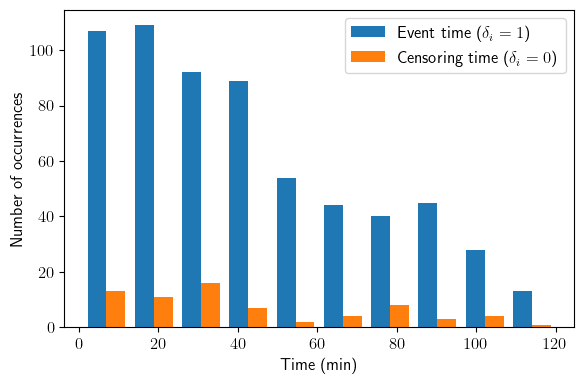

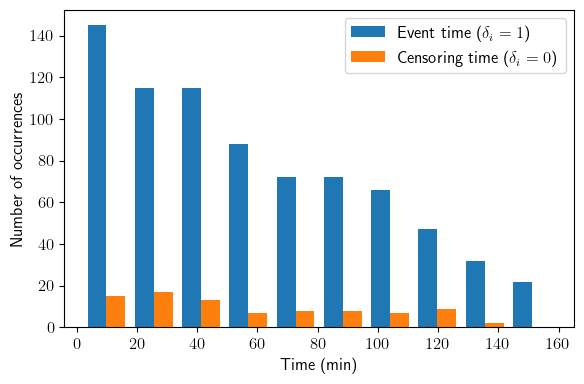

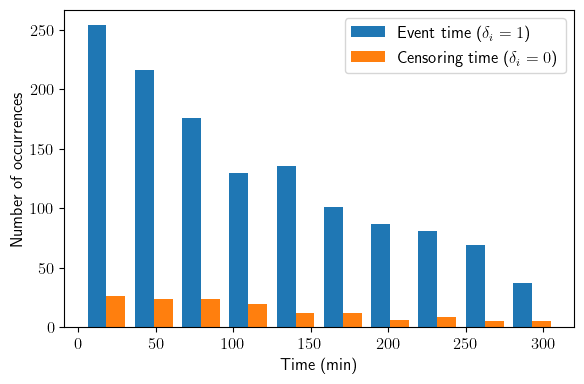

In [39]:
for cond in [0, 1, 2]:
    timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
    data_util = DataETL(DATASET, N_BOOT)
    data = pd.DataFrame()
    window_size = get_window_size(cond)
    lag = get_lag(cond)
    bearing_indicies = list(range(1, (N_BEARING*2)+1))
    for idx in bearing_indicies:
        event_time = data_util.event_analyzer(idx, info_pack)
        transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
        data = pd.concat([data, transformed_data], axis=0)
    
    data = data.reset_index(drop=True)
    censored_data = Formatter.control_censored_data(data, percentage=0.1)
    
    n_censored = data.shape[0] - data["Event"].sum()
    print ("There are {} samples censored from a total of {} samples".format(n_censored, data.shape[0]))
    print("%.1f%% of records are censored" % (n_censored / data.shape[0] * 100))

    plt.figure(figsize=(6, 4))
    val, bins, patches = plt.hist((data["Survival_time"][data["Event"]],
                                data["Survival_time"][~data["Event"]]),
                                bins=10,
                                stacked=False)
    plt.legend(patches, ["Event time (" + r"$\delta_{i} = 1$" + ")", "Censoring time (" + r"$\delta_{i} = 0$" + ")"])
    plt.xlabel("Time (min)")
    plt.ylabel("Number of occurrences")
    plt.tight_layout()
    plt.savefig(f'{PLOTS_PATH}/event_times_cond_{cond+1}.pdf',
                format='pdf', bbox_inches="tight")

 42%|████▏     | 42/100 [00:03<00:04, 12.77it/s]


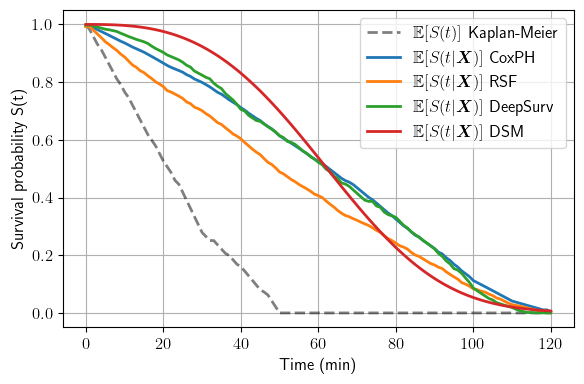

In [37]:
for cond in [0]:
    # Build timeseries data
    timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)

    train_data, test_data = pd.DataFrame(), pd.DataFrame()
    window_size = get_window_size(cond)
    lag = get_lag(cond)
    train_idx = list(range(1, 7))
    test_idx = list(range(7, 11))
    
    for idx in train_idx:
        event_time = data_util.event_analyzer(idx, info_pack)
        transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
        train_data = pd.concat([train_data, transformed_data], axis=0)
    for idx in test_idx:
        event_time = data_util.event_analyzer(idx, info_pack)
        transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
        test_data = pd.concat([test_data, transformed_data], axis=0)
    
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    
    train_data = Formatter.control_censored_data(train_data, percentage=0.1)
    test_data = Formatter.control_censored_data(test_data, percentage=0.1)
    train_data = train_data.sample(frac=1, random_state=0)
    test_data = test_data.sample(frac=1, random_state=0)

    x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
    y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
    x_test = test_data.drop(['Event', 'Survival_time'], axis=1)
    y_test = Surv.from_dataframe("Event", "Survival_time", test_data)

    #Set event times for models
    event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
    event_times = np.unique(event_times)

    #Set the feature selector and train/test split
    best_features = PHSelector(x_train, y_train, estimator=[DATASET, cond]).get_features()
    X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

    # Scale data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Format the data for NN models
    t_train = y_train['Survival_time']
    e_train = y_train['Event']
    t_test = y_test['Survival_time']
    e_test = y_test['Event']

    #Make models
    cph_model = CoxPH().make_model(CoxPH().get_best_hyperparams())
    rsf_model = RSF().make_model(RSF().get_best_hyperparams())
    deep_surv_model = DeepSurv().make_model(DeepSurv().get_best_hyperparams())
    dsm_model = DSM().make_model(DSM().get_best_hyperparams())
    #bnn_model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())

    #Train model
    deepsurv_params = DeepSurv().get_best_hyperparams()
    dsm_params = DSM().get_best_hyperparams()
    cph_model.fit(X_train_scaled, y_train)
    rsf_model.fit(X_train_scaled, y_train)
    deep_surv_model.fit(X_train_scaled, t_train, e_train, vsize=0.3,
                    iters=deepsurv_params['iters'],
                    learning_rate=deepsurv_params['learning_rate'],
                    batch_size=deepsurv_params['batch_size'])
    dsm_model.fit(X_train_scaled, t_train, e_train, vsize=0.3,
                iters=dsm_params['iters'],
                learning_rate=dsm_params['learning_rate'],
                batch_size=dsm_params['batch_size'])
    #bnn_model.fit(X_train_scaled, t_train, e_train)

    #Predict
    survival = Survival()
    cph_surv_func = survival.predict_survival_function(cph_model, X_test_scaled, event_times)
    rsf_surv_func = survival.predict_survival_function(rsf_model, X_test_scaled, event_times)
    deep_surv_surv_func = survival.predict_survival_function(deep_surv_model, X_test_scaled, event_times)
    dsm_surv_func = survival.predict_survival_function(dsm_model, X_test_scaled, event_times)
    #bnn_surv_func = survival.predict_survival_function(bnn_model, X_test_scaled, event_times,
                                                       #n_post_samples=N_POST_SAMPLES)
    km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                           y_test['Event'].reshape(1,-1),
                                                           event_times)
    plt.figure(figsize=(6, 4))
    plt.plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=0.5, label=r"$\mathbb{E}[S(t)]$ Kaplan-Meier", color="black")
    plt.plot(event_times, np.mean(cph_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ CoxPH", color="C0", linewidth=2)
    plt.plot(event_times, np.mean(rsf_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ RSF", color="C1", linewidth=2)
    plt.plot(event_times, np.mean(deep_surv_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ DeepSurv", color="C2", linewidth=2)
    plt.plot(event_times, np.mean(dsm_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ DSM", color="C3", linewidth=2)
    #plt.plot(event_times, np.mean(bnn_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ BNNSurv", color="C4", linewidth=2)
    plt.xlabel("Time (min)")
    plt.ylabel("Survival probability S(t)")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.savefig(f'{PLOTS_PATH}/mean_survival_cond_{cond+1}.pdf', format='pdf', bbox_inches="tight")

In [33]:
print(list(range(1, 7)))
print(list(range(7, 11)))

[1, 2, 3, 4, 5, 6]
[7, 8, 9, 10]


In [ ]:
# Build timeseries data
cond = 1
timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
window_size = get_window_size(cond)
lag = get_lag(cond)
train_idx = list(range(1, 9)) # bearings 1-6 for train
test_idx = list(range(9, 11)) # bearings 7-10 for test

train_data, test_data = pd.DataFrame(), pd.DataFrame()
for idx in train_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    train_data = pd.concat([train_data, transformed_data], axis=0)
for idx in test_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    test_data = pd.concat([test_data, transformed_data], axis=0)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data = Formatter.control_censored_data(train_data, percentage=0.1)
test_data = Formatter.control_censored_data(test_data, percentage=0.1)
train_data = train_data.sample(frac=1, random_state=0)
test_data = test_data.sample(frac=1, random_state=0)

x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
x_test = test_data.drop(['Event', 'Survival_time'], axis=1)
y_test = Surv.from_dataframe("Event", "Survival_time", test_data)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(x_train, y_train, estimator=[DATASET, cond]).get_features()
X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

#Format the data for NN models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

# Split data
features_to_split = best_features
for feature in features_to_split:
    X_train_feature, X_test_feature = pd.DataFrame(X_train[feature]), pd.DataFrame(X_test[feature])

    # Scale train data
    scaler = StandardScaler()
    scaler.fit(X_train_feature)
    X_train_scaled = scaler.transform(X_train_feature)

    #model.fit(X_train, y_train)
    #model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())
    model = DeepSurv().make_model(DeepSurv().get_best_hyperparams())
    model.fit(X_train_scaled, t_train, e_train)
    split_thresholds = []
    for qct in [0.25, 0.5, 0.75]:
        split_thresholds.append(round(X_test_feature[feature].quantile(qct), 2))
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, st in enumerate(split_thresholds):
        g1_idx = X_test_feature.loc[X_test_feature[feature] < st].index
        g2_idx = X_test_feature.loc[X_test_feature[feature] >= st].index
        X_test_g1 = X_test_feature.loc[g1_idx]
        X_test_g2 = X_test_feature.loc[g2_idx]
        y_test_g1 = y_test[g1_idx]
        y_test_g2 = y_test[g2_idx]

        # Scale splitted data
        X_test_scaled = scaler.transform(X_test_feature)
        X_test_g1_scaled = scaler.transform(X_test_g1)
        X_test_g2_scaled = scaler.transform(X_test_g2)

        # Predict for mean and two groups
        survival = Survival()
        surv_probs = survival.predict_survival_function(model, X_test_scaled, event_times,
                                                        n_post_samples=N_POST_SAMPLES)
        km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                               y_test['Event'].reshape(1,-1),
                                                               event_times)
        surv_probs_g1 = survival.predict_survival_function(model, X_test_g1_scaled, event_times,
                                                           n_post_samples=N_POST_SAMPLES)
        km_mean_g1, km_high_g1, km_low_g1 = calculate_kaplan_vectorized(y_test_g1['Survival_time'].reshape(1,-1),
                                                                        y_test_g1['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_g2 = survival.predict_survival_function(model, X_test_g2_scaled, event_times,
                                                           n_post_samples=N_POST_SAMPLES)
        km_mean_g2, km_high_g2, km_low_g2 = calculate_kaplan_vectorized(y_test_g2['Survival_time'].reshape(1,-1),
                                                                        y_test_g2['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_mean = np.mean(surv_probs, axis=0)
        surv_probs_g1_mean = np.mean(surv_probs_g1, axis=0)
        surv_probs_g2_mean = np.mean(surv_probs_g2, axis=0)
        
        # Plot
        axes[i].plot(surv_probs_mean, linewidth=2, label=r"$\mathbb{E}[S(t|$" + f"{feature}" + r"$)]$", color="black")
        axes[i].plot(surv_probs_g1_mean, linewidth=2, label=r"$S(t|$" + f"{feature} $<{st})$", color="C0")
        axes[i].plot(surv_probs_g2_mean, linewidth=2, label=r"$S(t|$" + f"{feature} $\geq{st})$", color="C1")
        axes[i].plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=0.5, color="black")
        axes[i].plot(km_mean_g1.columns, km_mean_g1.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C0")
        axes[i].plot(km_mean_g2.columns, km_mean_g2.iloc[0], 'k--', linewidth=2, alpha=0.5, color="C1")
        axes[i].set_xlabel("Time (min)")
        axes[i].set_ylabel("Survival probability S(t)")
        axes[i].legend(loc='upper right')
        axes[i].grid(True)
        fig.tight_layout()
        fig.show()
    plt.savefig(f'{PLOTS_PATH}/group_survival_{feature}_cond_{cond+1}.pdf',
                format='pdf', bbox_inches="tight")

In [19]:
list(range(6, N_BEARING*2+1))

[6, 7, 8, 9, 10]

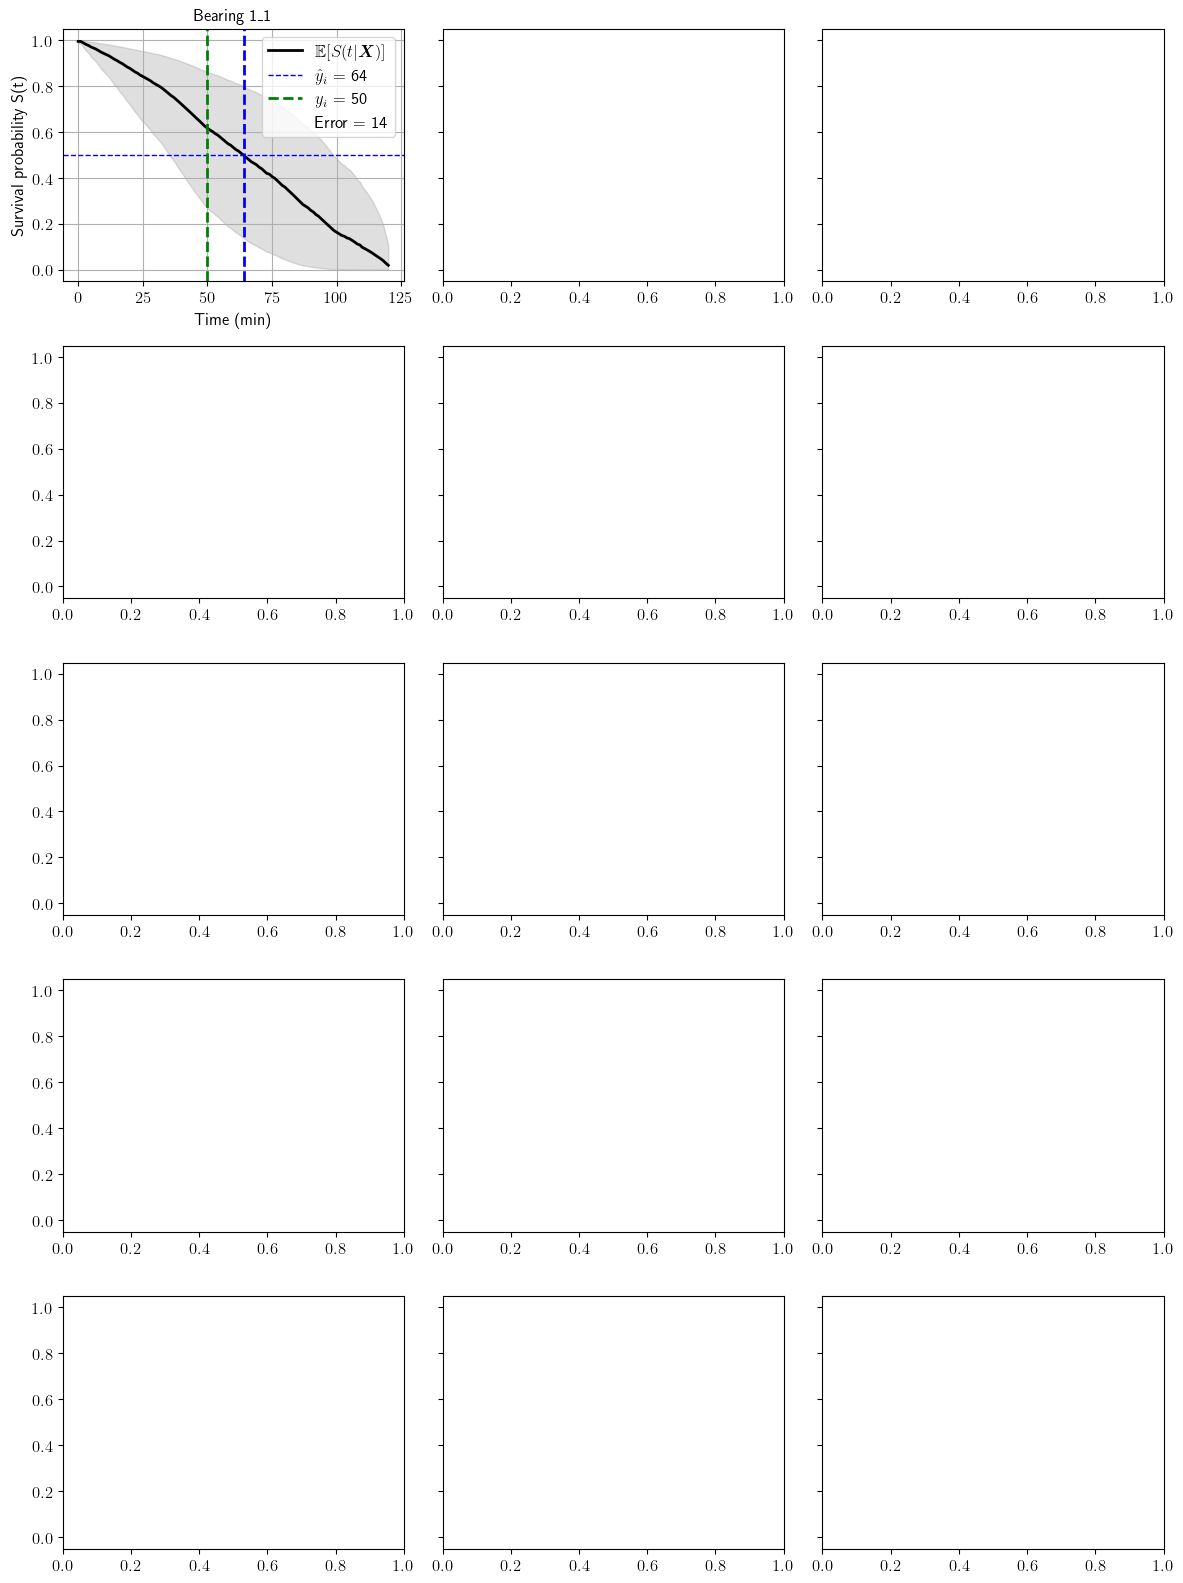

In [24]:
from matplotlib.patches import Rectangle

data_util = DataETL(DATASET, N_BOOT)
fig, axes = plt.subplots(5, 3, figsize=(12, 16), sharey=True)

for cond in [0, 1, 2]:
    # Build timeseries data
    timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
    window_size = get_window_size(cond)
    lag = get_lag(cond)
    
    # Individual bearing prediction
    bearings = list(range(1, N_BEARING+1)) #list(range(6, N_BEARING*2+1))
    for test_idx in bearings:
        train_idx = [x for x in bearings if x != test_idx]
        
        train_data = pd.DataFrame()
        for idx in train_idx:
            event_time = data_util.event_analyzer(idx, info_pack)
            transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
            train_data = pd.concat([train_data, transformed_data], axis=0)
            
        test_event_time = data_util.event_analyzer(test_idx, info_pack)
        test_data = data_util.make_moving_average(timeseries_data, test_event_time, test_idx, window_size, lag)
    
        train_data = train_data.reset_index(drop=True)
        test_data = test_data.reset_index(drop=True)
        
        train_data = Formatter.control_censored_data(train_data, percentage=0.1)
        test_data = Formatter.control_censored_data(test_data, percentage=0.1)
        train_data = train_data.sample(frac=1, random_state=0)
        test_data = test_data.sample(frac=1, random_state=0)
        
        # Select only first observation
        test_data = test_data[test_data['Survival_time'] == test_data['Survival_time'].max()] \
                    .drop_duplicates(subset="Survival_time")

        x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
        y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
        x_test = test_data.drop(['Event', 'Survival_time'], axis=1)
        y_test = Surv.from_dataframe("Event", "Survival_time", test_data)

        #Set event times for models
        event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
        event_times = np.unique(event_times)

        #Set the feature selector and train/test split
        best_features = PHSelector(x_train, y_train, estimator=[DATASET, cond]).get_features()
        X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

        # Scale data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #Format the data
        t_train = y_train['Survival_time']
        e_train = y_train['Event']
        t_test = y_test['Survival_time']
        e_test = y_test['Event']
        
        # Set event time
        failure_time = data_util.event_analyzer(test_idx, info_pack)
        
        #Set up the models on test
        model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())

        # Train the model
        model.fit(X_train_scaled, t_train, e_train)
        
        # Predict
        surv_probs = model.predict_survival(X_test_scaled, event_times, N_POST_SAMPLES)
        median_outputs = pd.DataFrame(np.mean(surv_probs, axis=0), columns=event_times)
        
        # Calculate TTE
        lifelines_eval = LifelinesEvaluator(median_outputs.T, t_test, e_test, t_train, e_train)
        median_survival_time = round(np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time)))
        mae = lifelines_eval.mae(method="Hinge")
        
        # Plot
        plot_idx = test_idx-1
        p1 = axes[plot_idx, cond].plot(np.mean(median_outputs, axis=0).T, linewidth=2, label=r"$\mathbb{E}[S(t|\bm{X})]$", color="black")
        drop_num = math.floor(0.5 * N_POST_SAMPLES * (1 - 0.9))
        lower_outputs = torch.kthvalue(torch.from_numpy(surv_probs), k=1+drop_num, dim=0)[0]
        upper_outputs = torch.kthvalue(torch.from_numpy(surv_probs), k=N_POST_SAMPLES-drop_num, dim=0)[0]
        axes[plot_idx, cond].fill_between(event_times, upper_outputs[0,:], lower_outputs[0,:], color="gray", alpha=0.25)
        p2 = axes[plot_idx, cond].axhline(y=0.5, linestyle= "dashed", color='blue', linewidth=1, label='$\hat{y}_{i}$ = ' + f'{median_survival_time}')        
        p3 = axes[plot_idx, cond].axvline(x=test_event_time, linestyle= "dashed",
                                          color='green', linewidth=2.0, label=f'$y_i$ = {int(test_event_time)}')
        axes[plot_idx, cond].axvline(x=int(median_survival_time), linestyle= "dashed", color='blue', linewidth=2.0)
        axes[plot_idx, cond].set_title(f'Bearing {cond+1}_{test_idx}')
        axes[plot_idx, cond].set_xlabel("Time (min)")
        text = f'Error = {int(median_survival_time-test_event_time)}'
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        axes[plot_idx, cond].legend([p1[0], p2, p3, extra], [p1[0].get_label(), p2.get_label(), p3.get_label(), text], loc='upper right')
        if cond == 0:
            axes[plot_idx, cond].set_ylabel("Survival probability S(t)")
        axes[plot_idx, cond].grid(True)
        break
    break
plt.tight_layout()
plt.savefig(f'{PLOTS_PATH}/individual_survival_{min(bearings)}_{max(bearings)}.pdf', format='pdf', bbox_inches="tight")